## Github Classroom

Repository : https://github.com/cs418-fa24/project-check-in-team-7

## Project description

This project focuses on predicting the likelihood of diabetic patients being readmitted to the hospital within 30 days. By leveraging a dataset containing information about patient encounters, including demographic details, medical history, diagnosis codes, and treatment data, the goal is to develop a model that can identify high-risk patients.
By predicting which patients are most likely to be readmitted, hospitals can allocate resources more effectively, prioritize interventions for high-risk individuals, and improve patient care.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv("diabetic_data_initial.csv")

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Data Exploration

In [4]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (101766, 50)


In [5]:
# print(df.describe())

In [6]:
# # Display unique values for categorical columns
# object_columns = df.select_dtypes(include=['object'])
# object_columns.head(10)
# for column in object_columns:
#     unique_values = df[column].unique()
#     print(f"Unique values in '{column}': {unique_values}\n")

## Data Preprocessing

In [7]:
df.replace('?', np.nan, inplace=True)

In [8]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
max_glu_serum        96420
A1Cresult            84748
dtype: int64


In [9]:
# Drop columns with multiple missing values
df = df.drop(columns=['weight', 'payer_code', 'medical_specialty','discharge_disposition_id','admission_source_id'])

In [10]:
# Drop rows where the race column has missing values
df = df.dropna(subset=['race'])

In [11]:
# Drop columns with only one unique value
df = df.drop(columns=['examide', 'citoglipton','metformin-rosiglitazone'])

In [12]:
df['max_glu_serum'].unique()

array([nan, '>300', 'Norm', '>200'], dtype=object)

In [13]:
# Replace the values in the 'max_glu_serum' column with more descriptive categories
df['max_glu_serum'] = df['max_glu_serum'].replace({
    '>300': 'Very High',
    '>200': 'High',
    'Norm': 'Normal',
    np.nan: 'No test performed'
})

print(df['max_glu_serum'].unique())

['No test performed' 'Very High' 'Normal' 'High']


In [14]:
df['A1Cresult'].unique()

array([nan, '>7', '>8', 'Norm'], dtype=object)

In [15]:
# Replace the values in the 'A1Cresult' column with more descriptive categories
df['A1Cresult'] = df['A1Cresult'].replace({
    '>8': 'Very High',
    '>7': 'High',
    'Norm': 'Normal',
    np.nan: 'No test performed'
})

print(df['A1Cresult'].unique())

['No test performed' 'High' 'Very High' 'Normal']


In [16]:
# Mapping of diagnosis categories with corresponding ICD-9 code ranges
categories = {
    'Circulatory': ['390-459', '785'],
    'Respiratory': ['460-519', '786'],
    'Digestive': ['520-579', '787'],
    'Diabetes': ['250.xx'],
    'Injury': ['800-999'],
    'Musculoskeletal': ['710-739'],
    'Genitourinary': ['580-629', '788'],
    'Neoplasms': ['140-239','780', '781', '784', '790-799','240-249', '251-279','680-709', '001-139'],
    'Other': [
        '290-319', 'E', 'V', '280-289', '320-359', '630-679', '360-389',
        '740-759'
    ]
}

def categorize_diagnosis(code):
    if pd.isna(code):
        return 'Unknown'
    code = str(code)

    for category, ranges in categories.items():
        for icd_range in ranges:
            if '-' in icd_range:
                start, end = icd_range.split('-')
                if start <= code <= end:
                    return category
            elif icd_range.endswith('xx') and code.startswith(icd_range[:3]):
                return category
            elif code.startswith(icd_range):
                return category
    return 'Other'

df['primary_diagnosis'] = df['diag_1'].apply(categorize_diagnosis)
df['secondary_diagnosis'] = df['diag_2'].apply(categorize_diagnosis)
df['additional_diagnosis'] = df['diag_3'].apply(categorize_diagnosis)


df[['diag_1', 'primary_diagnosis', 'diag_2', 'secondary_diagnosis', 'diag_3', 'additional_diagnosis']].head()


,diag_1,primary_diagnosis,diag_2,secondary_diagnosis,diag_3,additional_diagnosis
0,250.83,Diabetes,NaN,Unknown,NaN,Unknown
1,276,Neoplasms,250.01,Diabetes,255,Neoplasms
2,648,Other,250,Diabetes,V27,Other
3,8,Other,250.43,Diabetes,403,Circulatory
4,197,Neoplasms,157,Neoplasms,250,Diabetes


In [17]:
df = df.drop(columns=['diag_1', 'diag_2', 'diag_3'])

In [18]:
# Map the numerical 'admission_type_id' to descriptive labels
admission_type_mapping = {
    1: 'Emergency',
    2: 'Urgent',
    3: 'Elective',
    4: 'Newborn',
    5: 'Not Available',
    6: 'NULL',
    7: 'Trauma Center',
    8: 'Not Mapped'
}

df['admission_type'] = df['admission_type_id'].replace(admission_type_mapping)
df = df.drop(columns=['admission_type_id'])

## Visualizations:

The plot presents the distribution of the number of lab procedures, procedures, and medications for a group of patients. The histograms show that the distribution of lab procedures and medications is right-skewed, meaning there are a few patients with many procedures and medications. At the same time, the majority have a lower number. The number of procedures is more evenly distributed, with a peak around 1. This suggests that most patients undergo only one procedure during their hospital stay.

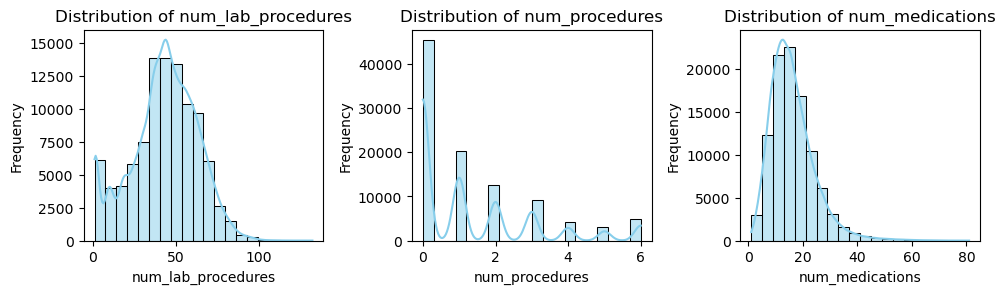

In [19]:
# Select the features of interest
features = ['num_lab_procedures', 'num_procedures', 'num_medications']

# Summary Statistics
summary_stats = df[features].describe(percentiles=[.25, .5, .75])
# print("Summary Statistics for Lab and Procedure Counts:")
# print(summary_stats)

# Visualization: Histograms for each feature
plt.figure(figsize=(10, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], bins=20, kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The plots illustrate the frequency of medication changes and diabetes medication prescriptions within a dataset. The left plot shows that a majority of patients experienced medication changes (1 represents a change, 0 represents no change).
The right plot indicates that a significant proportion of patients were prescribed diabetes medication (1 represents a prescription, 0 represents no prescription). Both plots highlight the prevalence of medication adjustments and diabetes management within the studied population.
The plot presents the frequency of medication changes based on diabetes medication status. It shows that patients who were prescribed diabetes medication (indicated by 1) were more likely to experience medication changes compared to those who were not prescribed diabetes medication (indicated by 0). This suggests that diabetes medication use is associated with a higher frequency of medication adjustments, potentially due to the need for careful management of blood sugar levels and other related factors.

Frequency of Medication Changes (change):
change
No    53582
Ch    45911
Name: count, dtype: int64

Frequency of Diabetes Medication (diabetesMed):
diabetesMed
Yes    76492
No     23001
Name: count, dtype: int64


C:\Users\sudha\AppData\Local\Temp\ipykernel_9876\3786669805.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=change_counts.index, y=change_counts.values, palette='Set1')
C:\Users\sudha\AppData\Local\Temp\ipykernel_9876\3786669805.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diabetesMed_counts.index, y=diabetesMed_counts.values, palette='Set2')


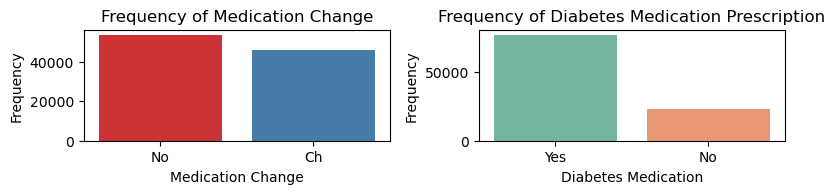


Cross-tabulation of Change and Diabetes Medication:
diabetesMed     No    Yes
change                   
Ch               0  45911
No           23001  30581


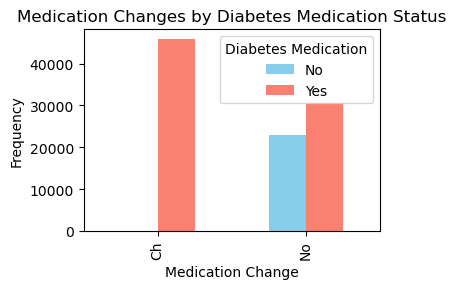

In [20]:
# Frequency counts for 'change' and 'diabetesMed'
change_counts = df['change'].value_counts()
diabetesMed_counts = df['diabetesMed'].value_counts()

# Display frequency counts
print("Frequency of Medication Changes (change):")
print(change_counts)
print("\nFrequency of Diabetes Medication (diabetesMed):")
print(diabetesMed_counts)

# Visualization: Bar charts for 'change' and 'diabetesMed'
plt.figure(figsize=(12, 5))

# Bar chart for 'change'
plt.subplot(3, 3, 1)
sns.barplot(x=change_counts.index, y=change_counts.values, palette='Set1')
plt.title('Frequency of Medication Change')
plt.xlabel('Medication Change')
plt.ylabel('Frequency')

# Bar chart for 'diabetesMed'
plt.subplot(3, 3, 2)
sns.barplot(x=diabetesMed_counts.index, y=diabetesMed_counts.values, palette='Set2')
plt.title('Frequency of Diabetes Medication Prescription')
plt.xlabel('Diabetes Medication')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Cross-tabulation of 'change' and 'diabetesMed'
change_diabetesMed_ct = pd.crosstab(df['change'], df['diabetesMed'])

# Display cross-tabulation
print("\nCross-tabulation of Change and Diabetes Medication:")
print(change_diabetesMed_ct)

# Visualization: Side-by-side bar chart for cross-tabulation
change_diabetesMed_ct.plot(kind='bar', color=['skyblue', 'salmon'], figsize=(4, 3))
plt.title('Medication Changes by Diabetes Medication Status')
plt.xlabel('Medication Change')
plt.ylabel('Frequency')
plt.legend(title='Diabetes Medication')
plt.tight_layout()
plt.show()

The plot presents the readmission rates of patients based on their age group. It shows the count of patients who were not readmitted, readmitted within 30 days, and readmitted after 30 days, categorized by their age group. The plot reveals that the highest number of patients were in the 50-60 age group, and the readmission rates were highest in the 70-80 age group, particularly within 30 days.

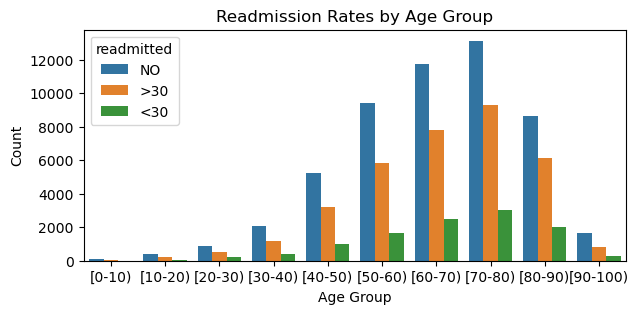

In [21]:
plt.figure(figsize=(7, 3))
sns.countplot(x='age', hue='readmitted', data=df)
plt.title('Readmission Rates by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

The plot presents the readmission rates of patients based on their admission type. It shows the count of patients who were not readmitted, readmitted within 30 days, and readmitted after 30 days, categorized by their admission type. The plot reveals that the highest number of patients were admitted via Emergency, and the readmission rates were highest for Emergency and Urgent admissions, particularly within 30 days.

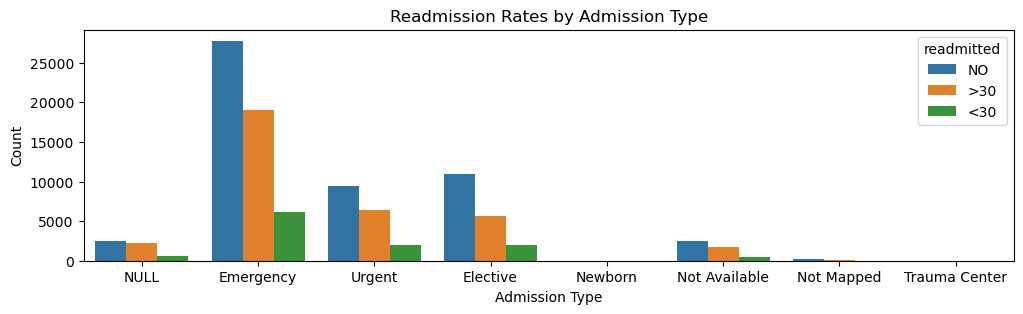

In [22]:
plt.figure(figsize=(12, 3))
# Filter out rows where 'admission_type' is null
df_filtered = df[df['admission_type'].notna()]

sns.countplot(x='admission_type', hue='readmitted', data=df_filtered)
plt.title('Readmission Rates by Admission Type')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.show()

The plot presents the readmission rates of patients based on the time they spent in the hospital. It shows the count of patients who were not readmitted, readmitted within 30 days, and readmitted after 30 days, categorized by their length of stay. The plot reveals that the readmission rates decrease as the length of stay increases. This suggests that longer hospital stays might be associated with fewer readmissions. Longer stays might enable the hosiptals to take better care of the patients so hospitals should consider investing into that.

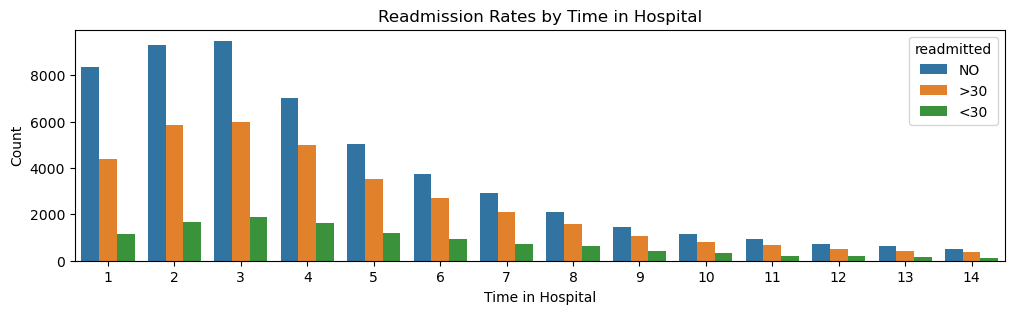

In [23]:
plt.figure(figsize=(12, 3))
sns.countplot(x='time_in_hospital', hue='readmitted', data=df)
plt.title('Readmission Rates by Time in Hospital')
plt.xlabel('Time in Hospital')
plt.ylabel('Count')
plt.show()


The plot presents the readmission rates of patients based on their insulin use. It shows the count of patients who were not readmitted, readmitted within 30 days, and readmitted after 30 days, categorized by whether they were not on insulin, had their insulin dose increased, had their insulin dose kept steady, or had their insulin dose decreased. The plot reveals that patients with no insulin use had the highest readmission rates, particularly within 30 days. Patients with increased insulin dose had the lowest readmission rates. This result makes sense on a diabetic dataset.

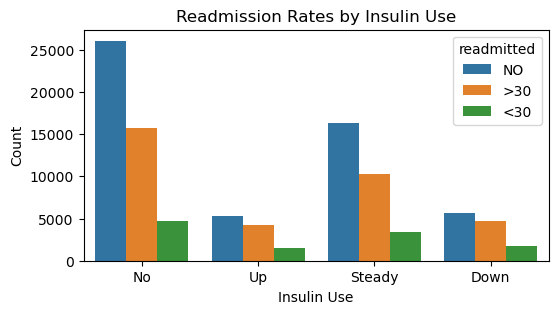

In [24]:
plt.figure(figsize=(6, 3))
sns.countplot(x='insulin', hue='readmitted', data=df)
plt.title('Readmission Rates by Insulin Use')
plt.xlabel('Insulin Use')
plt.ylabel('Count')
plt.show()

The plot presents the readmission rates of patients based on their primary diagnosis. It shows the count of patients who were not readmitted, readmitted within 30 days, and readmitted after 30 days, categorized by their primary diagnosis. The plot reveals that the highest number of patients were admitted with Circulatory and Diabetes as the primary diagnosis. Circulatory diagnoses had the highest readmission rates, particularly within 30 days.

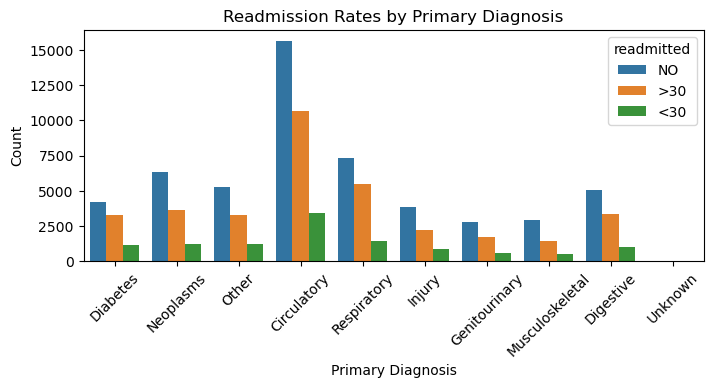

In [25]:
plt.figure(figsize=(8, 3))
sns.countplot(x='primary_diagnosis', hue='readmitted', data=df)
plt.title('Readmission Rates by Primary Diagnosis')
plt.xlabel('Primary Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming your DataFrame is called 'df'

def plot_readmission_overview(df):
    """Create an overview of readmission distribution"""
    plt.figure(figsize=(4, 4))

    # Calculate readmission distribution
    readmission_dist = df['readmitted'].value_counts()

    # Create bar plot
    sns.barplot(x=readmission_dist.index, y=readmission_dist.values)
    plt.title('Distribution of Readmission Status', fontsize=14)
    plt.xlabel('Readmission Status', fontsize=12)
    plt.ylabel('Number of Patients', fontsize=12)

    # Add percentage labels on top of bars
    total = len(df)
    for i, v in enumerate(readmission_dist.values):
        plt.text(i, v, f'{(v/total)*100:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def plot_age_readmission(df):
    """Analyze readmission patterns across age groups"""
    plt.figure(figsize=(7, 3))

    # Create cross-tabulation of age and readmission
    age_readmission = pd.crosstab(df['age'], df['readmitted'], normalize='index') * 100

    # Create stacked bar plot
    age_readmission.plot(kind='bar', stacked=True)
    plt.title('Readmission Rates by Age Group', fontsize=14)
    plt.xlabel('Age Group', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.legend(title='Readmission Status')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plot_diagnosis_impact(df):
    """Analyze impact of primary diagnosis on readmission"""
    plt.figure(figsize=(6, 3))

    # Calculate readmission rates by diagnosis
    diagnosis_readmission = pd.crosstab(df['primary_diagnosis'],
                                      df['readmitted'].map({'NO': 'Not Readmitted',
                                                          '<30': 'Within 30 Days',
                                                          '>30': 'After 30 Days'}),
                                      normalize='index') * 100

    # Create heatmap
    sns.heatmap(diagnosis_readmission, annot=True, fmt='.1f', cmap='YlOrRd')
    plt.title('Readmission Rates by Primary Diagnosis (%)', fontsize=14)
    plt.xlabel('Readmission Status', fontsize=12)
    plt.ylabel('Primary Diagnosis', fontsize=12)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 3))

    # Calculate readmission rates by diagnosis
    diagnosis_readmission = pd.crosstab(df['secondary_diagnosis'],
                                      df['readmitted'].map({'NO': 'Not Readmitted',
                                                          '<30': 'Within 30 Days',
                                                          '>30': 'After 30 Days'}),
                                      normalize='index') * 100

    # Create heatmap
    sns.heatmap(diagnosis_readmission, annot=True, fmt='.1f', cmap='YlOrRd')
    plt.title('Readmission Rates by Secondary Diagnosis (%)', fontsize=14)
    plt.xlabel('Readmission Status', fontsize=12)
    plt.ylabel('Secondary Diagnosis', fontsize=12)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 3))


    # Calculate readmission rates by diagnosis
    diagnosis_readmission = pd.crosstab(df['additional_diagnosis'],
                                      df['readmitted'].map({'NO': 'Not Readmitted',
                                                          '<30': 'Within 30 Days',
                                                          '>30': 'After 30 Days'}),
                                      normalize='index') * 100

    # Create heatmap
    sns.heatmap(diagnosis_readmission, annot=True, fmt='.1f', cmap='YlOrRd')
    plt.title('Readmission Rates by Additional Diagnosis (%)', fontsize=14)
    plt.xlabel('Readmission Status', fontsize=12)
    plt.ylabel('Additional Diagnosis', fontsize=12)

    plt.tight_layout()
    plt.show()

def plot_time_in_hospital_analysis(df):
    """Analyze relationship between time in hospital and readmission"""
    plt.figure(figsize=(4, 3))

    # Create violin plot
    sns.violinplot(x='readmitted', y='time_in_hospital', data=df)
    plt.title('Time in Hospital Distribution by Readmission Status', fontsize=14)
    plt.xlabel('Readmission Status', fontsize=12)
    plt.ylabel('Days in Hospital', fontsize=12)

    plt.tight_layout()
    plt.show()

def plot_medication_impact(df):
    """Analyze impact of number of medications on readmission"""
    plt.figure(figsize=(4, 3))

    # Create box plot
    sns.boxplot(x='readmitted', y='num_medications', data=df)
    plt.title('Number of Medications vs Readmission Status', fontsize=14)
    plt.xlabel('Readmission Status', fontsize=12)
    plt.ylabel('Number of Medications', fontsize=12)

    plt.tight_layout()
    plt.show()

def plot_lab_procedures_analysis(df):
    """Analyze relationship between lab procedures and readmission"""
    plt.figure(figsize=(5, 4))

    # Calculate average number of lab procedures for each readmission status
    lab_proc_means = df.groupby('readmitted')['num_lab_procedures'].mean()

    # Create bar plot
    sns.barplot(x=lab_proc_means.index, y=lab_proc_means.values)
    plt.title('Average Number of Lab Procedures by Readmission Status', fontsize=14)
    plt.xlabel('Readmission Status', fontsize=12)
    plt.ylabel('Average Number of Lab Procedures', fontsize=12)

    # Add value labels on top of bars
    for i, v in enumerate(lab_proc_means.values):
        plt.text(i, v, f'{v:.1f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Function to run all visualizations
def analyze_readmissions(df):
    """Run all visualization analyses"""
    plot_readmission_overview(df)
    plot_age_readmission(df)
    plot_diagnosis_impact(df)
    plot_time_in_hospital_analysis(df)
    plot_medication_impact(df)
    plot_lab_procedures_analysis(df)

The plot presents the distribution of readmission status for a group of patients. It shows that the majority of patients (53.6%) were not readmitted, followed by 35.2% who were readmitted after 30 days, and 11.2% who were readmitted within 30 days of their initial discharge. This indicates that while a significant portion of patients avoid readmission, a considerable number still require further hospitalizations, particularly within the first 30 days post-discharge.

The plot presents the readmission rates for patients based on their primary diagnosis. It shows the percentage of patients who were not readmitted, readmitted within 30 days, and readmitted after 30 days, categorized by their primary diagnosis. The plot reveals that patients with circulatory and respiratory issues tend to have higher readmission rates, particularly within 30 days. Conversely, patients with musculoskeletal and neoplasm diagnoses have lower readmission rates. Unknown diagnoses have the highest readmission rate within 30 days.

The plot presents the readmission rates for patients based on their secondary diagnosis. It shows the percentage of patients who were not readmitted, readmitted within 30 days, and readmitted after 30 days, categorized by their secondary diagnosis. The plot reveals that patients with circulatory and respiratory issues tend to have higher readmission rates, particularly within 30 days. Conversely, patients with musculoskeletal and neoplasm diagnoses have lower readmission rates. Unknown diagnoses have the highest readmission rate within 30 days.

The plot presents the readmission rates for patients based on their additional diagnosis. It shows the percentage of patients who were not readmitted, readmitted within 30 days, and readmitted after 30 days, categorized by their additional diagnosis. The plot reveals that patients with circulatory and respiratory issues tend to have higher readmission rates, particularly within 30 days. Conversely, patients with musculoskeletal and neoplasm diagnoses have lower readmission rates. Unknown diagnoses have the highest readmission rate within 30 days.

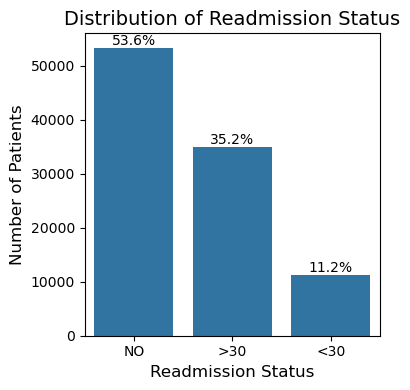

C:\Users\sudha\AppData\Local\Temp\ipykernel_9876\1950236035.py:65: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


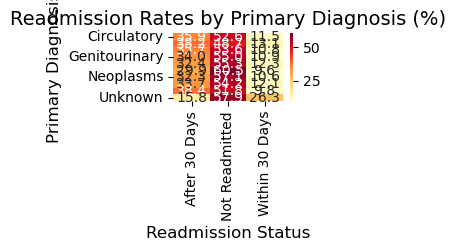

C:\Users\sudha\AppData\Local\Temp\ipykernel_9876\1950236035.py:84: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


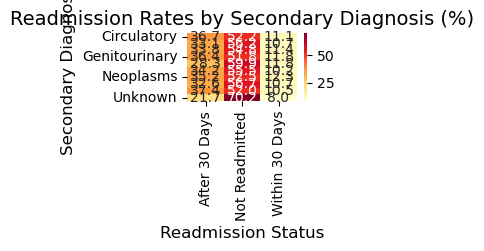

C:\Users\sudha\AppData\Local\Temp\ipykernel_9876\1950236035.py:103: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


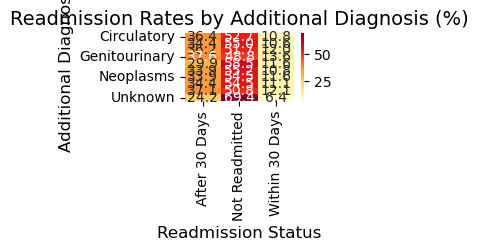

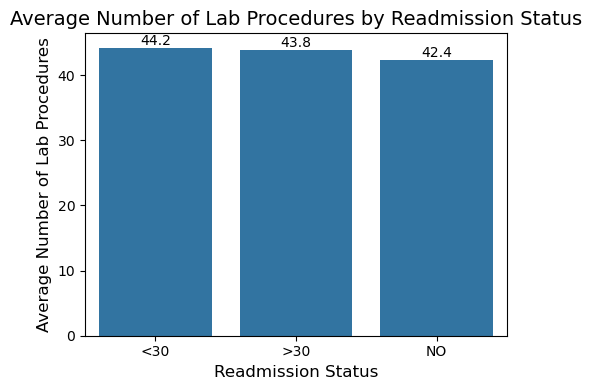

In [27]:
plot_readmission_overview(df)
plot_diagnosis_impact(df)

plot_lab_procedures_analysis(df)

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def plot_diabetes_medication_impact(df):
    """Analyze the impact of diabetes medications on readmission"""

    # List of diabetes medications
    medications = ['metformin', 'insulin', 'glipizide', 'glyburide', 'pioglitazone',
                   'rosiglitazone', 'glimepiride']

    # Initialize subplots
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    # Calculate readmission rates for each medication and plot
    for idx, med in enumerate(medications):
        # Filter out the medication status for each value
        med_status = df[med].map({'No': 'Not prescribed', 'Steady': 'Steady', 'Up': 'Increased', 'Down': 'Decreased'})

        # Calculate the readmission rates, convert to DataFrame, and plot
        rates = pd.crosstab(med_status, df['readmitted'], normalize='index') * 100
        rates = rates.apply(pd.to_numeric, errors='coerce')  # Ensure numeric type

        # Plot each medication impact
        rates.plot(kind='bar', ax=axes[idx])
        axes[idx].set_title(f'{med.capitalize()} Impact')
        axes[idx].set_xlabel('Medication Status')
        axes[idx].set_ylabel('Readmission Rate (%)')
        axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def plot_individual_diagnosis_readmission(df):
    """Create separate plots for each diagnosis type in relation to readmission"""

    # Plot for primary diagnosis
    plt.figure(figsize=(8, 6))
    sns.countplot(x='primary_diagnosis', hue='readmitted', data=df)
    plt.title('Primary Diagnosis vs. Readmission Status', fontsize=14)
    plt.xlabel('Primary Diagnosis', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot for secondary diagnosis
    plt.figure(figsize=(8, 6))
    sns.countplot(x='secondary_diagnosis', hue='readmitted', data=df)
    plt.title('Secondary Diagnosis vs. Readmission Status', fontsize=14)
    plt.xlabel('Secondary Diagnosis', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot for additional diagnosis
    plt.figure(figsize=(8, 6))
    sns.countplot(x='additional_diagnosis', hue='readmitted', data=df)
    plt.title('Additional Diagnosis vs. Readmission Status', fontsize=14)
    plt.xlabel('Additional Diagnosis', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_advanced_readmissions(df):
     """Run all advanced visualization analyses"""
     plot_diabetes_medication_impact(df)
     plot_individual_diagnosis_readmission(df)

**Plot: Diabetes Medication Impact on Readmission**
The bars represent the percentage of patients who were readmitted, grouped by medication status. Higher bars indicate higher readmission rates, suggesting the impact of that medication status on readmission. The plot illustrates the readmission rates of patients based on their medication status for various diabetes medications. Notably, Metformin and Pioglitazone saw increased readmission rates when doses were decreased or the drug was discontinued, respectively. Conversely, Insulin demonstrated the lowest readmission rate when doses were decreased. For Glipizide, Glyburide, Rosiglitazone, and Glimepiride, the highest readmission rates were observed in patients who were not prescribed these medications.

The three plots— **Primary Diagnosis, Secondary Diagnosis, and Additional Diagnosis vs. Readmission** — show the distribution of readmission rates across different diagnosis types. They highlight how primary, secondary, and additional diagnoses influence the likelihood of readmission, offering insights for targeted interventions based on diagnosis type.
The plot presents the readmission rates of patients based on their primary, secondary, and additional diagnoses. The x-axis categorizes the diagnoses into groups like diabetes, neoplasms, circulatory, etc., while the y-axis represents the count of patients. The bars are color-coded to indicate the readmission status: blue for not readmitted, orange for readmitted within 30 days, and green for readmitted after 30 days. The plots show that diabetes is a common primary diagnosis, and circulatory diseases are frequent secondary and additional diagnoses. The readmission rates vary across different diagnoses, with some categories showing higher rates of readmission compared to others.

In [29]:
#analyze_advanced_readmissions(df) # comment out this line to see all plots

In [30]:
# Hypothesis Testing

import pandas as pd
from scipy.stats import chi2_contingency

df_new = df
# Create a contingency table of the two categorical variables: 'readmitted' and 'race'
contingency_table = pd.crosstab(df_new['readmitted'], df_new['age'])
# Perform the Chi-Square Test of Independence
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display the results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

# Conclusion based on p-value
if p_value < 0.05:
    print("Reject the null hypothesis: The distribution of readmission rates is dependent on age.")
else:
    print("Fail to reject the null hypothesis: The distribution of readmission rates is independent of age.")

Chi-Square Statistic: 300.102712096902
P-Value: 4.587201696582658e-53
Degrees of Freedom: 18
Expected Frequencies: 
[[   17.96146463    76.56074297   180.84949695   415.24661031
   1062.53289176  1896.61840531  2468.35427618  2859.12839094
   1885.95378569   305.79393525]
 [   56.29662388   239.9643593    566.83663172  1301.5075734
   3330.29715658  5944.57162815  7736.56353713  8961.36696049
   5911.14550772   958.45002161]
 [   85.74191149   365.47489773   863.31387133  1982.24581629
   5072.16995165  9053.80996653 11783.08218669 13648.50464857
   9002.90070658  1459.75604314]]
Reject the null hypothesis: The distribution of readmission rates is dependent on age.


In [31]:
#Conversion of The dataset to numeric values to work with statistical machine learning models more easily

df_categorical = df
# Drop irrelevant features
df = df.drop(columns=['encounter_id', 'patient_nbr'])

# Step 1: Encoding Demographic and Categorical Features
# List of categorical features for one-hot encoding
one_hot_features = ['race', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'admission_type']

# List of categorical features for ordinal encoding
ordinal_features = {
    'age': ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'],
    'max_glu_serum': ['No test performed', 'Normal', 'High', 'Very High'],
    'A1Cresult': ['No test performed', 'Normal', 'High', 'Very High'],
    'metformin': ['No', 'Down', 'Steady', 'Up'],
    'repaglinide': ['No', 'Down', 'Steady', 'Up'],
    'nateglinide': ['No', 'Down', 'Steady', 'Up'],
    'chlorpropamide': ['No', 'Down', 'Steady', 'Up'],
    'glimepiride': ['No', 'Down', 'Steady', 'Up'],
    'acetohexamide': ['No', 'Steady'],
    'glipizide': ['No', 'Down', 'Steady', 'Up'],
    'glyburide': ['No', 'Down', 'Steady', 'Up'],
    'tolbutamide': ['No', 'Steady'],
    'pioglitazone': ['No', 'Down', 'Steady', 'Up'],
    'rosiglitazone': ['No', 'Down', 'Steady', 'Up'],
    'acarbose': ['No', 'Down', 'Steady', 'Up'],
    'miglitol': ['No', 'Down', 'Steady', 'Up'],
    'troglitazone': ['No', 'Steady'],
    'tolazamide': ['No', 'Steady', 'Up'],
    'insulin': ['No', 'Down', 'Steady', 'Up'],
    'glyburide-metformin': ['No', 'Down', 'Steady', 'Up'],
    'glipizide-metformin': ['No', 'Steady'],
    'glimepiride-pioglitazone': ['No', 'Steady'],
    'metformin-pioglitazone': ['No', 'Steady']
}

# Step 2: Encoding Binary Features
binary_features = ['gender', 'change', 'diabetesMed']
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1, 'Unknown/Invalid': 2})
df['change'] = df['change'].map({'No': 0, 'Ch': 1})
df['diabetesMed'] = df['diabetesMed'].map({'No': 0, 'Yes': 1})

# Encoding 'readmitted' (ordinal target variable)
df['readmitted'] = df['readmitted'].map({'NO': 0, '>30': 1, '<30': 2})

# Step 3: Numerical Features
# List of numerical features
num_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

# Step 4: Pipeline Setup
# Define preprocessing for categorical, ordinal, and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), one_hot_features),
        ('ordinal', OrdinalEncoder(categories=list(ordinal_features.values())), list(ordinal_features.keys()))
    ],
    remainder='passthrough'
)

# Step 5: Transform the Data
df_transformed = preprocessor.fit_transform(df)

# Convert transformed data back to DataFrame for better interpretability
# Get one-hot encoded feature names
one_hot_encoded_columns = preprocessor.named_transformers_['onehot'].get_feature_names_out(one_hot_features)
# Combine all feature names after transformation
feature_names = list(one_hot_encoded_columns) + list(ordinal_features.keys()) + num_features + binary_features + ['readmitted']
df_transformed = pd.DataFrame(df_transformed, columns=feature_names)

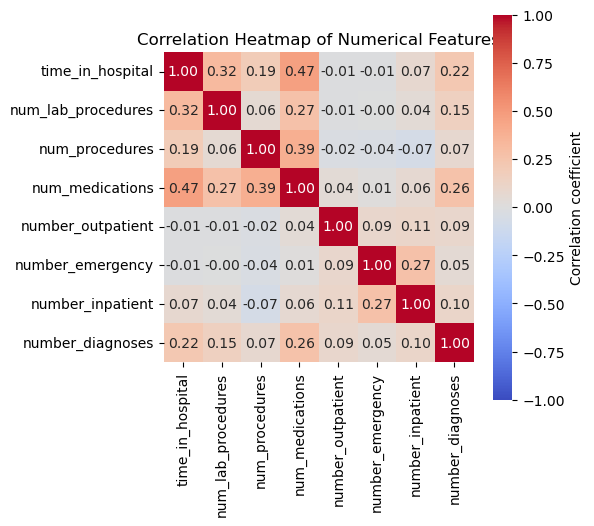

In [32]:
# Selecting numerical columns for correlation analysis
numerical_features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'
]

# Calculating the correlation matrix
correlation_matrix = df[numerical_features].corr()

# # Displaying the correlation matrix
# print("Correlation Matrix:")
# print(correlation_matrix)

# Plotting the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, fmt=".2f",
            cbar_kws={'label': 'Correlation coefficient'})
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


High multicollinearity results from a linear relationship between independent variables with a high degree of correlation. The stronger the correlation, the more difficult it is to change one variable without changing another. It becomes difficult for the model to estimate the relationship between each independent variable and the dependent variable independently because the independent variables tend to change in unison. Our Dataset has no features that are highly correlated.

In [33]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

if df['readmitted'].dtype == 'object':
    label_encoder = LabelEncoder()
    df['readmitted'] = label_encoder.fit_transform(df['readmitted'])

for col in categorical_columns:
    if col != 'readmitted':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

# F-statistic (ANOVA)
f_stat_results = {}
for col in numerical_columns:
    f_stat, p_value = f_classif(df[[col]], df['readmitted'])
    f_stat_results[col] = (f_stat[0], p_value[0])

print("ANOVA (F-statistic) and p-values for numerical columns:")
for col, (f_stat, p_value) in f_stat_results.items():
    print(f"Column: {col}, F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")



ANOVA (F-statistic) and p-values for numerical columns:
Column: gender, F-statistic: 17.6734, p-value: 0.0000
Column: time_in_hospital, F-statistic: 166.0344, p-value: 0.0000
Column: num_lab_procedures, F-statistic: 76.6418, p-value: 0.0000
Column: num_procedures, F-statistic: 97.4852, p-value: 0.0000
Column: num_medications, F-statistic: 135.2908, p-value: 0.0000
Column: number_outpatient, F-statistic: 334.5015, p-value: 0.0000
Column: number_emergency, F-statistic: 556.0974, p-value: 0.0000
Column: number_inpatient, F-statistic: 2891.9429, p-value: 0.0000
Column: number_diagnoses, F-statistic: 608.3438, p-value: 0.0000
Column: change, F-statistic: 106.1892, p-value: 0.0000
Column: diabetesMed, F-statistic: 196.6221, p-value: 0.0000
Column: readmitted, F-statistic: inf, p-value: 0.0000


c:\Users\sudha\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


##Statistical Analysis- ANNOVA

ANOVA tests whether each feature has a statistically significant relationship with the target variable readmitted.

**Key Findings**
Highly Significant Features (p-value < 0.05):

Examples: encounter_id, patient_nbr, time_in_hospital, metformin, repaglinide, glipizide, primary_diagnosis.
Interpretation: These features have a strong relationship with readmission, meaning they are important predictors.

Not Significant Features (p-value > 0.05):

Examples: race, nateglinide, chlorpropamide, insulin.
Interpretation: These features do not significantly affect the likelihood of readmission.



In [34]:
from sklearn.model_selection import train_test_split
X = df_transformed.drop(columns=['readmitted'])
y = df_transformed['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Naive Bayes Accuracy: 0.13

Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.05      0.09     10666
         1.0       0.45      0.01      0.02      7058
         2.0       0.11      0.96      0.20      2175

    accuracy                           0.13     19899
   macro avg       0.41      0.34      0.10     19899
weighted avg       0.53      0.13      0.07     19899



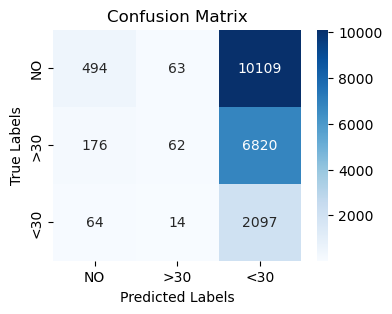

In [35]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["NO", ">30", "<30"], yticklabels=["NO", ">30", "<30"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [36]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

class SimpleMulticlassLogisticRegression:
    def __init__(self, learning_rate=0.01, num_epochs=1000):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weights = None
        self.bias = None

    def softmax(self, logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    def compute_loss(self, predictions, y):
        m = len(y)
        loss = -np.mean(np.sum(y * np.log(predictions + 1e-15), axis=1))
        return loss

    def one_hot_encode(self, y, num_classes):
        return np.eye(num_classes)[y]

    def fit(self, X, y):
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        self.weights = np.random.randn(num_features, num_classes) * 0.01
        self.bias = np.zeros((1, num_classes))

        y_encoded = self.one_hot_encode(y, num_classes)

        for epoch in range(self.num_epochs):
            logits = np.dot(X, self.weights) + self.bias
            predictions = self.softmax(logits)

            loss = self.compute_loss(predictions, y_encoded)

            grad_logits = predictions - y_encoded
            grad_weights = np.dot(X.T, grad_logits) / num_samples
            grad_bias = np.mean(grad_logits, axis=0, keepdims=True)

            self.weights -= self.learning_rate * grad_weights
            self.bias -= self.learning_rate * grad_bias

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        logits = np.dot(X, self.weights) + self.bias
        predictions = self.softmax(logits)
        return np.argmax(predictions, axis=1)

    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model = SimpleMulticlassLogisticRegression(learning_rate=0.01, num_epochs=400)

model.fit(X_train, y_train_encoded)
y_pred = model.predict(X_test)


test_accuracy = model.accuracy(y_test_encoded, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Epoch 0, Loss: 1.4930619972091708
Epoch 100, Loss: 9.065701127205719
Epoch 200, Loss: 4.915429019121216
Epoch 300, Loss: 5.844223899294507
Test Accuracy: 0.36976732499120557


Accuracy: 0.57

Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      0.92      0.71     10666
         1.0       0.51      0.20      0.28      7058
         2.0       0.50      0.00      0.00      2175

    accuracy                           0.57     19899
   macro avg       0.53      0.37      0.33     19899
weighted avg       0.54      0.57      0.48     19899



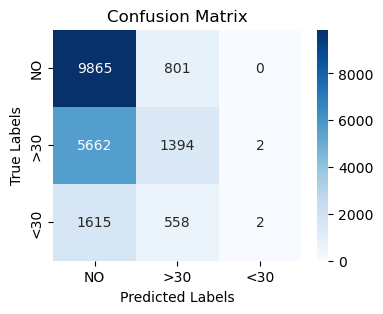

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Remove non-significant features based on p-value > 0.05 from ANOVA results
significant_features = [ 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'diabetesMed']
X = df_transformed[significant_features]
y = df_transformed['readmitted']

# Proceed with train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=500, solver='liblinear')

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report for precision, recall, and F1 score
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["NO", ">30", "<30"], yticklabels=["NO", ">30", "<30"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

significant_features = [ 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'diabetesMed']
X = df_transformed[significant_features]
y = df_transformed['readmitted']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf_model, param_grid, scoring='accuracy', cv=3)
grid_rf.fit(X_train, y_train)

best_rf_model = grid_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest with Tuning Accuracy: {accuracy:.2f}")

#Display classification report for precision, recall, and F1 score
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["NO", ">30", "<30"], yticklabels=["NO", ">30", "<30"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define SVM hyperparameters for grid search
param_grid_svm = {
    'C': [0.1, 1, 10],            # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Linear and RBF kernels
    'gamma': ['scale', 'auto'],   # Kernel coefficient for RBF
}

# Initialize SVM model
svm_model = SVC(random_state=42)

# Perform Grid Search with cross-validation
grid_svm = GridSearchCV(svm_model, param_grid_svm, scoring='accuracy', cv=3)
grid_svm.fit(X_train, y_train)

# Best model after Grid Search
best_svm_model = grid_svm.best_estimator_

# Make predictions on test set
y_pred_svm = best_svm_model.predict(X_test)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM with Tuning Accuracy: {svm_accuracy:.2f}")

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

# Confusion Matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["NO", ">30", "<30"], yticklabels=["NO", ">30", "<30"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SVM")
plt.show()


**ML Model Analysis**


The results from the machine learning model, based on the significant features identified in the ANOVA analysis, show mixed performance. The Logistic Regression model achieved an overall test accuracy of 0.57, indicating moderate success in predicting readmission outcomes. The model performed well in predicting non-readmitted patients (Class 0) with a recall of 0.92 and an F1-score of 0.71, suggesting good results for identifying patients who won’t be readmitted. However, the model struggled significantly with predicting readmission cases. The recall for patients readmitted after more than 30 days (Class 1) was low at 0.20, and for those readmitted within 30 days (Class 2), the recall was zero, meaning the model failed to identify any early readmissions. This suggests that while the model can correctly classify non-readmissions, it misses crucial readmission cases, especially the early ones. Possible reasons for this include class imbalance, where non-readmissions dominate the dataset, and limitations in the Logistic Regression model’s ability to capture complex relationships in the data. To improve performance, addressing class imbalance, trying more advanced models, and exploring better feature engineering would be key steps to enhance predictive accuracy across all classes.

## Reflection
- What is the hardest part of the project that you’ve encountered so far? Hardest part was to find how many features to retain after checking for correlation analysis.
- What are your initial insights? Age is a major factor in determining readmission; another major factor is Admission type - when they get admitted as Emergency, there is higher chance of readmission.
- Going forward, what are the current biggest problems you’re facing? - Finding the right model to fit to the data.
- Do you think you are on track with your project? If not, what parts do you need to dedicate more time t? Yes.


## Roles & Coordination
- Finding Data Sources - All members
- Cleaning, preprocessing, feature engineering - Jaimin Babaria, Rujuta Tambewagh
- Visualization, Exploratory Data Analysis - Vishak Baddur, Sudha Sree Yerramsetty
- Statistical Analysis - Sudha Sree Yerramsetty, Varsha Balaji
- Model training and  evaluation- Varsha Balaji, Simran Mishra